In [31]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from ae_model import Autoencoder
from sklearn.decomposition import PCA

The autoencoder model is pre-trained from previous project: [interactive_denoiser](https://github.com/ShlomiRex/interactive_denoiser)

Its simple autoencoder with 3 CNN layers (and the decoder is the reverse of the encoder).

In [32]:
# Load the pretrained model
model = Autoencoder(128)
model.load_state_dict(torch.load("ae_model.pth"))

# Set the model to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

C:\Users\Shlomi\AppData\Local\Temp\ipykernel_1392\3359886163.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ae_model.pth"))


Autoencoder(
  (enc_conv1): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_relu1): ReLU()
  (enc_conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (enc_relu2): ReLU()
  (enc_conv3): Conv2d(256, 128, kernel_size=(7, 7), stride=(1, 1))
  (enc_linear): Linear(in_features=128, out_features=128, bias=True)
  (dec_linear): Linear(in_features=128, out_features=128, bias=True)
  (dec_conv1): ConvTranspose2d(128, 256, kernel_size=(7, 7), stride=(1, 1))
  (dec_relu1): ReLU()
  (dec_conv2): ConvTranspose2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_relu2): ReLU()
  (dec_conv3): ConvTranspose2d(512, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (dec_tanh): Tanh()
)

In [33]:
dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

batch_size = 64
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
len(dataset)

10000

# View latent space of autoencoder

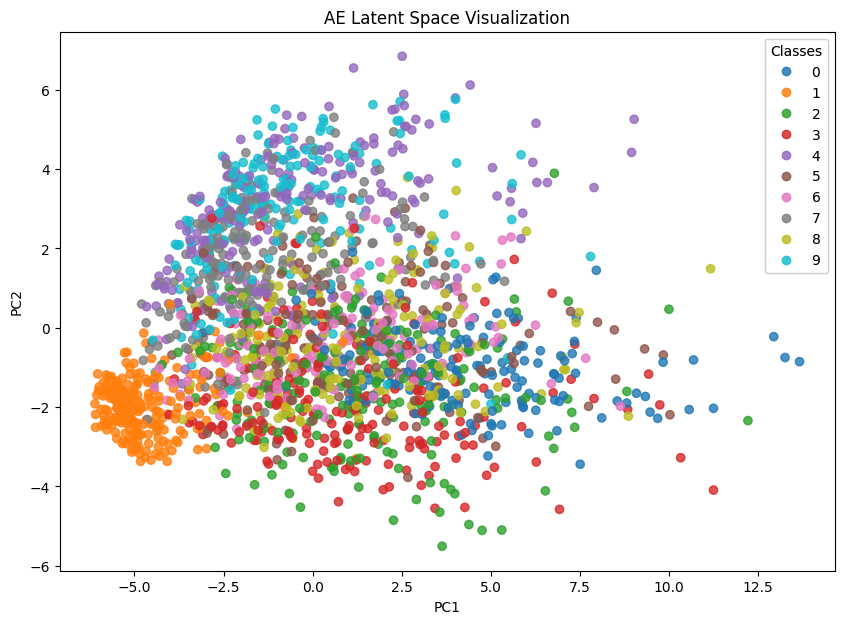

In [34]:
# Extract latent vectors from a subset of the test set
def extract_latent_vectors(loader, num_samples=500):
    latent_vectors = []
    labels = []
    count = 0

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            latent = model.encode(images).view(images.size(0), -1)  # Flatten latent space

            latent_vectors.append(latent.cpu())
            labels.append(targets)
            count += images.size(0)

            if count >= num_samples:  # Stop after collecting enough samples
                break

    latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
    labels = torch.cat(labels, dim=0)[:num_samples]
    return latent_vectors.numpy(), labels.numpy()

# Visualize the latent space
def plot_latent_space(latent_2d, labels):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    scatter = ax.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.8)
    ax.set_title('AE Latent Space Visualization')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

    # Add legend
    legend = ax.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
    ax.add_artist(legend)

    plt.show()


num_samples = 2_000
latent_vectors, labels = extract_latent_vectors(dataset_loader, num_samples)

# Reduce dimensionality to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)
plot_latent_space(latent_2d, labels)

The PCA analysis tells us the model is not learning the latent space well.

# Sample random latent vectors

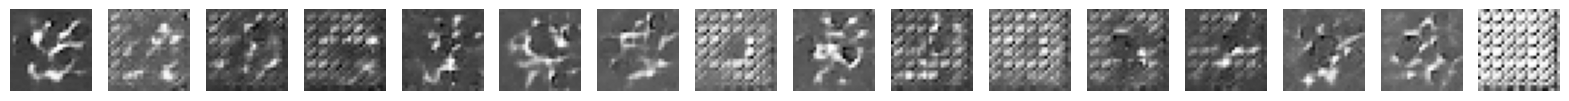

In [35]:
# Sample random latent vectors and decode them
n_samples = 16
latent_samples = torch.randn(n_samples, 128).to(device)
reconstructed_samples = model.decode(latent_samples).cpu()

# Visualize the reconstructed samples
fig, axes = plt.subplots(1, n_samples, figsize=(20, 2))

for i in range(n_samples):
    axes[i].imshow(reconstructed_samples[i].view(28, 28).detach().numpy(), cmap='gray')
    axes[i].axis('off')

plt.show()

## This is not VAE. This is AE. Every image is mapped to fixed latent vector. We can't interpolate between latent vectors. This is where Variational Autoencoder comes into play.

<img src="img.jpg" alt="Drawing" style="width: 800px;"/>

In [36]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import torch.nn as nn
from einops import rearrange
from torchsummary import summary
import torch.optim as optim
import math

Define the VAE model. All of the layers are exactly the same as the autoencoder model, except the latent space is now a distribution.

I also added fc_mu and fc_logvar layers. These layers are responsible for generating the latent space distribution.

We added sample method which takes in mean and logvar and samples from the distribution.

In [37]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.image_width = int(math.sqrt(input_dim))
        self.image_height = int(math.sqrt(input_dim))

        self.__setup_encoder()
        self.__setup_decoder()
    
    def __setup_encoder(self):
        self.enc_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.enc_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)

        self.relu = nn.ReLU()

        # Now we have two layers for each vector in latent space (going from hidden_dim to latent_dim)
        self.fc_mu = nn.Linear(self.hidden_dim, self.latent_dim)  # Mean vector
        self.fc_logvar = nn.Linear(self.hidden_dim, self.latent_dim)  # Log-variance vector

    def __setup_decoder(self):
        self.dec_fc1 = nn.Linear(self.latent_dim, self.hidden_dim)
        self.dec_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.dec_fc3 = nn.Linear(self.hidden_dim, self.input_dim)
    
    def encode(self, x):
        x = rearrange(x, 'b c h w -> b (c h w)') # Flatten the input
        x = self.relu(self.enc_fc1(x))
        x = self.relu(self.enc_fc2(x))

        mean = self.fc_mu(x)
        log_var = self.fc_logvar(x)

        # Here we don't return x, we return mean and log_var, this is different to AE
        return mean, log_var
    
    def decode(self, latent):
        x = self.relu(self.dec_fc1(latent))
        x = self.relu(self.dec_fc2(x))

        x_hat = torch.sigmoid(self.dec_fc3(x))

        x_hat = rearrange(x_hat, 'b (c h w) -> b c h w', c=1, h=self.image_width, w=self.image_height) # Reshape the output

        return x_hat
    
    def reparameterization(self, mean, var):
        """
        Variance is exponential of log_var
        """
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z


    def forward(self, x):
        assert x.shape[-3:] == (1, 28, 28)

        # Encode - instead of latent vector we get mean and log_var (look at image!)
        mean, log_var = self.encode(x)

        # Here is the magic of VAE
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        
        # Decode
        x_reconstructed = self.decode(z)

        # Return x hat
        return x_reconstructed, mean, log_var

In [38]:
def loss_function(x, x_hat, mean, log_var):
    # Reconstruction loss
    # recon_loss = nn.MSELoss()(x_hat, x)
    recon_loss = nn.BCELoss(reduction='sum')(x_hat, x)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

In [39]:
input_dim = 1 * 28 * 28
hidden_dim = 400
latent_dim = 200

vae = VariationalAutoencoder(input_dim, hidden_dim, latent_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)

summary(vae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         314,000
              ReLU-2                  [-1, 400]               0
            Linear-3                  [-1, 400]         160,400
              ReLU-4                  [-1, 400]               0
            Linear-5                  [-1, 200]          80,200
            Linear-6                  [-1, 200]          80,200
            Linear-7                  [-1, 400]          80,400
              ReLU-8                  [-1, 400]               0
            Linear-9                  [-1, 400]         160,400
             ReLU-10                  [-1, 400]               0
           Linear-11                  [-1, 784]         314,384
Total params: 1,189,984
Trainable params: 1,189,984
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

The VAE model has similar parameter count as the base autoencoder model.

The base AE model has 5,614,465 parameters.

# Without training, see the VAE reconstruction

In [40]:
del model # We don't need the AE model anymore
model = None
model = vae

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

In [41]:
# Transformations: Normalize and convert to tensor
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform = transforms.Compose([transforms.ToTensor()])  # See what happens if we dont normalize

# Load dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# DataLoader
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## See what happens when we try to reconstruct without training.

In [42]:
# # Select a single image from the test dataset
# single_image, _ = test_dataset[0]
# single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# # Pass the image through the encoder
# with torch.no_grad():
#     mean, log_var = model.encode(single_image)
#     latent_vector = model.sample(mean, log_var)
#     reconstructed = model.decode(latent_vector)  # Pass the latent vector through the decoder
# # Plot the original and reconstructed images
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(single_image.cpu().view(28, 28), cmap='gray')
# plt.title('Original Image')
# plt.axis('off')
# plt.subplot(1, 2, 2)
# plt.imshow(reconstructed.cpu().view(28, 28), cmap='gray')
# plt.title('Reconstructed Image')
# plt.axis('off')
# plt.show()


# Train the model on MNIST dataset

In [43]:
from tqdm import tqdm
import cv2
import numpy as np

In [44]:
# Training loop
num_epochs = 10

loss_history = []
kl_divergence_history = []
recon_loss_history = []

for epoch in range(num_epochs):
    model.train()

    overall_loss = 0

    # Use tqdm for progress tracking
    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as t:
        for images, _ in t:
            images = images.to(device)

            optimizer.zero_grad() # Zero gradients before performing a backward pass

            # Forward pass
            x_hat, mean, log_var = model(images)

            # Calculate loss
            loss, recon_loss, kl_loss = loss_function(images, x_hat, mean, log_var)

            # Add all three losses to history
            loss_history.append(loss.item())
            recon_loss_history.append(recon_loss.item())
            kl_divergence_history.append(kl_loss.item())

            overall_loss += loss.item()

            # Propagate the loss backward
            loss.backward() # Compute gradients (of KL + recon losses)
            optimizer.step() # Adjust weights of the model

            # # Update tqdm description with current loss
            t.set_postfix(loss=loss.item(), recon_loss=recon_loss.item(), kl_loss=kl_loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Recon Loss: {np.mean(recon_loss_history).item():.4f}, KL Loss: {np.mean(kl_divergence_history).item():.4f}")
    print("Average loss: ", overall_loss / len(train_loader))





Epoch [1/10]: 100%|██████████| 1875/1875 [00:16<00:00, 113.25it/s, kl_loss=502, loss=4.25e+3, recon_loss=3.74e+3]


Epoch [1/10], Recon Loss: 4864.4604, KL Loss: 374.3834
Average loss:  5238.843791927084


Epoch [2/10]: 100%|██████████| 1875/1875 [00:17<00:00, 108.84it/s, kl_loss=568, loss=3.76e+3, recon_loss=3.19e+3]


Epoch [2/10], Recon Loss: 4211.1318, KL Loss: 454.6370
Average loss:  4092.693888020833


Epoch [3/10]: 100%|██████████| 1875/1875 [00:17<00:00, 105.38it/s, kl_loss=583, loss=3.64e+3, recon_loss=3.05e+3]


Epoch [3/10], Recon Loss: 3863.5521, KL Loss: 489.5090
Average loss:  3727.6455673177084


Epoch [4/10]: 100%|██████████| 1875/1875 [00:17<00:00, 108.47it/s, kl_loss=580, loss=3.52e+3, recon_loss=2.94e+3]


Epoch [4/10], Recon Loss: 3656.5284, KL Loss: 510.2735
Average loss:  3608.02415625


Epoch [5/10]: 100%|██████████| 1875/1875 [00:16<00:00, 111.17it/s, kl_loss=586, loss=3.44e+3, recon_loss=2.85e+3]


Epoch [5/10], Recon Loss: 3519.0049, KL Loss: 524.5601
Average loss:  3550.6176227864585


Epoch [6/10]: 100%|██████████| 1875/1875 [00:17<00:00, 110.14it/s, kl_loss=598, loss=3.36e+3, recon_loss=2.76e+3]


Epoch [6/10], Recon Loss: 3419.5789, KL Loss: 535.5048
Average loss:  3512.6773798177082


Epoch [7/10]: 100%|██████████| 1875/1875 [00:16<00:00, 112.18it/s, kl_loss=618, loss=3.7e+3, recon_loss=3.08e+3] 


Epoch [7/10], Recon Loss: 3343.8770, KL Loss: 544.0298
Average loss:  3484.845154947917


Epoch [8/10]: 100%|██████████| 1875/1875 [00:17<00:00, 108.24it/s, kl_loss=580, loss=3.43e+3, recon_loss=2.85e+3]


Epoch [8/10], Recon Loss: 3283.6955, KL Loss: 551.1294
Average loss:  3463.2517376302085


Epoch [9/10]: 100%|██████████| 1875/1875 [00:17<00:00, 108.45it/s, kl_loss=626, loss=3.75e+3, recon_loss=3.13e+3]


Epoch [9/10], Recon Loss: 3233.5738, KL Loss: 557.2360
Average loss:  3438.6891903645833


Epoch [10/10]: 100%|██████████| 1875/1875 [00:17<00:00, 108.92it/s, kl_loss=581, loss=3.32e+3, recon_loss=2.74e+3]

Epoch [10/10], Recon Loss: 3190.7467, KL Loss: 562.6065
Average loss:  3416.24350703125


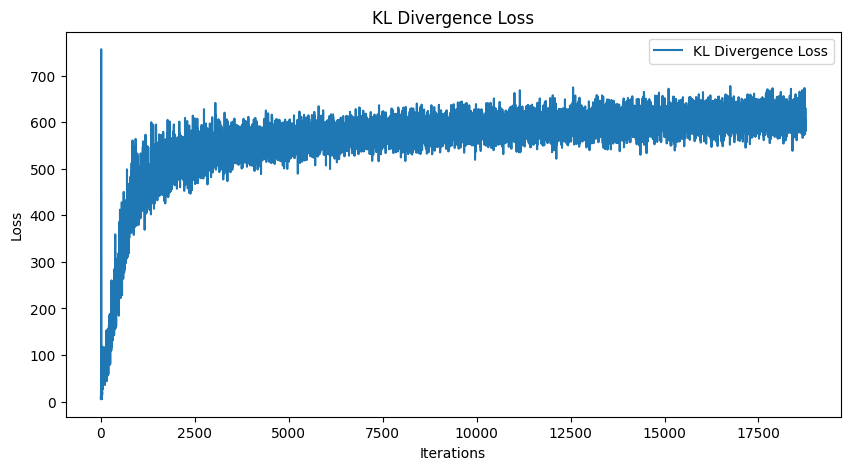

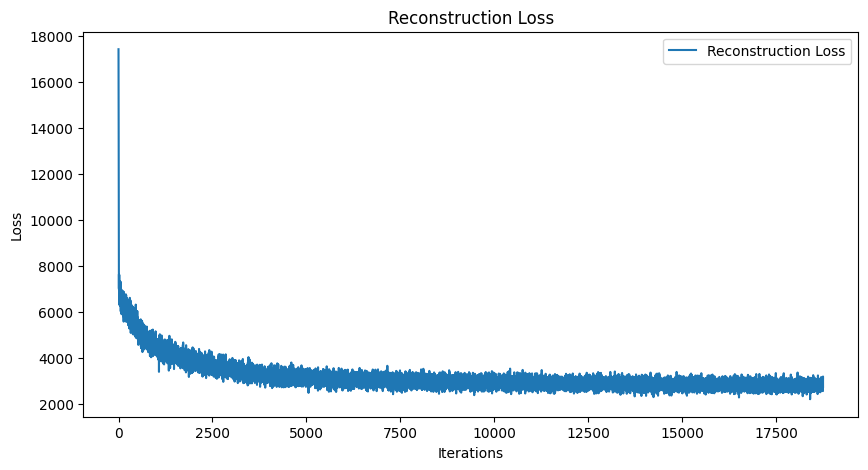

In [45]:
# Plot the log of the loss history, KL divergence in one graph and reconstruction loss in another.

plt.figure(figsize=(10, 5))
plt.plot(kl_divergence_history, label='KL Divergence Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('KL Divergence Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(recon_loss_history, label='Reconstruction Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Reconstruction Loss')
plt.legend()
plt.show()


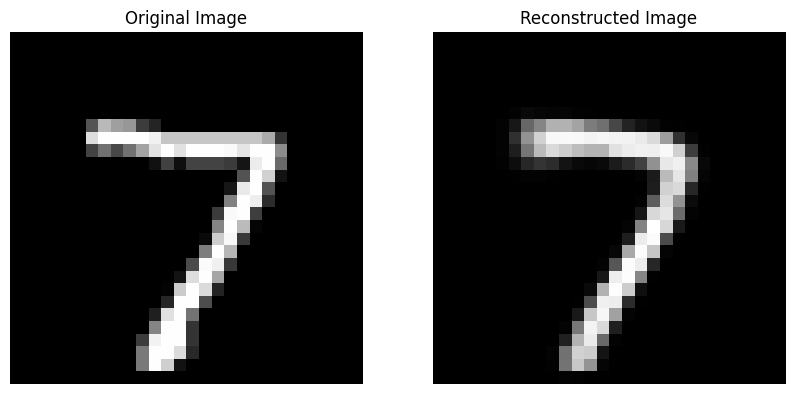

In [46]:
# Plot a single image and the reconstructed image
model.eval()
with torch.no_grad():
    single_image, _ = test_dataset[0]
    single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    reconstructed, _, _ = model(single_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(single_image.cpu().view(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed.cpu().view(28, 28), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()


# Visualize latent vector reconstruction

torch.Size([8, 1, 28, 28])


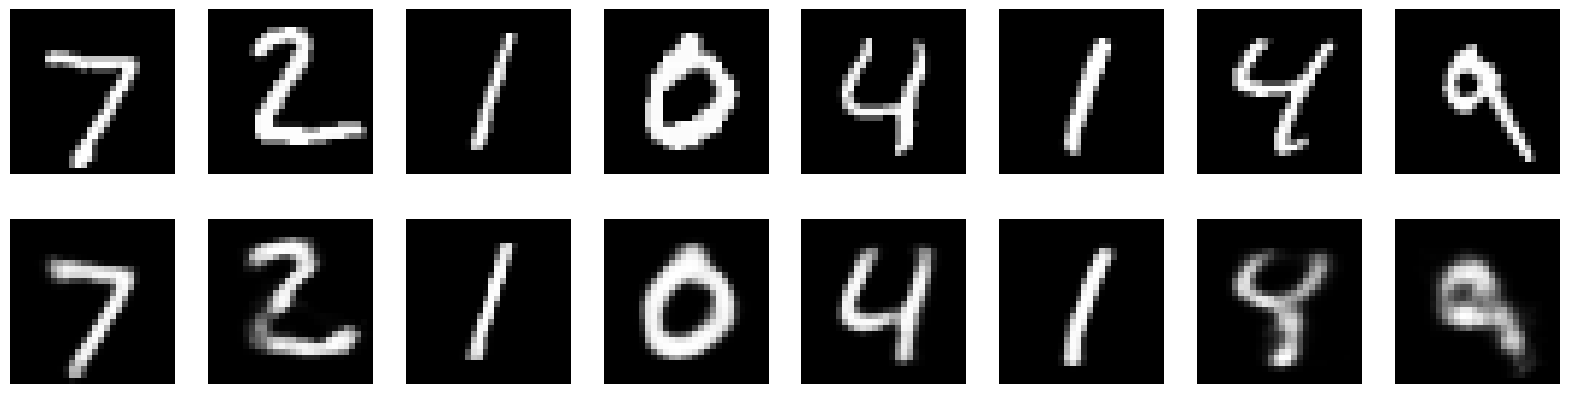

In [48]:
# Plot 8 images (original image) and to their right plot the reconstructed image
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images[:8].to(device)

    outputs, _, _ = model(images)

    images = images.cpu()
    outputs = outputs.cpu()

    print(outputs.shape)

    fig, axes = plt.subplots(2, 8, figsize=(20, 5))
    for i in range(8):
        axes[0, i].imshow(images[i].view(28, 28), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i].view(28, 28), cmap='gray')
        axes[1, i].axis('off')

    plt.show()

# Check if the model can denoise without explicitly training on noise data

In [49]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    """
    Adds Gaussian noise to a batch of images.
    
    Parameters:
    images (torch.Tensor): Batch of images.
    mean (float): Mean of the Gaussian noise.
    std (float): Standard deviation of the Gaussian noise.
    
    Returns:
    torch.Tensor: Noisy images.
    """
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images

def add_salt_and_pepper_noise(images, salt_prob=0.1, pepper_prob=0.1):
    """
    Adds salt and pepper noise to a batch of images.
    
    Parameters:
    images (torch.Tensor): Batch of images.
    salt_prob (float): Probability of adding salt noise.
    pepper_prob (float): Probability of adding pepper noise.
    
    Returns:
    torch.Tensor: Noisy images.
    """
    noisy_images = images.clone()
    salt_mask = torch.rand_like(images) < salt_prob
    pepper_mask = torch.rand_like(images) < pepper_prob
    noisy_images[salt_mask] = 1.0
    noisy_images[pepper_mask] = 0.0
    return noisy_images

def sample_value(mean, std):
    value = torch.randn(1) * std + mean
    return value.clamp(0, 1).item()

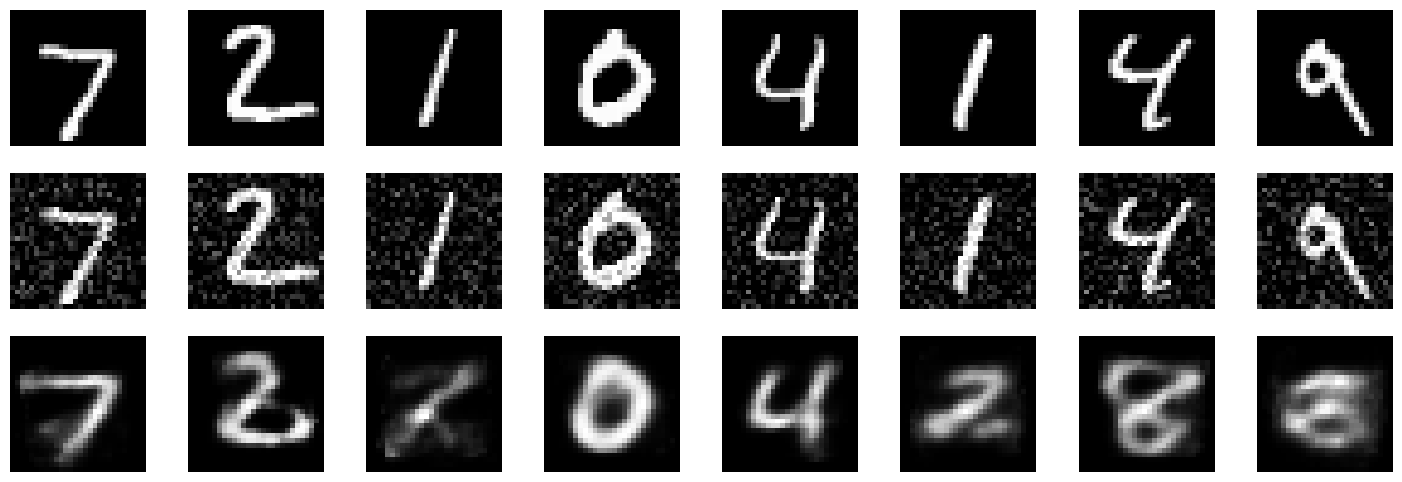

In [52]:
# Take 8 images from the test set, add noise and reconstruct
images, _ = next(iter(test_loader))
images = images[:8]

# Add Gaussian noise
noisy_images = add_gaussian_noise(images, std=sample_value(0.2, 0.2))
noisy_images = noisy_images.to(device)

# Reconstruct the images
model.eval()
with torch.no_grad():
    reconstructed, _, _ = model(noisy_images)
    # Plot original, noisy and reconstructed images
    fig, axes = plt.subplots(3, 8, figsize=(18, 6))
    for images, row in zip([images, noisy_images, reconstructed], axes):
        for img, ax in zip(images, row):
            img = img.to('cpu')
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()

Surprisingly, the model can denoise the images without being trained on noisy data.

# Sample from latent space

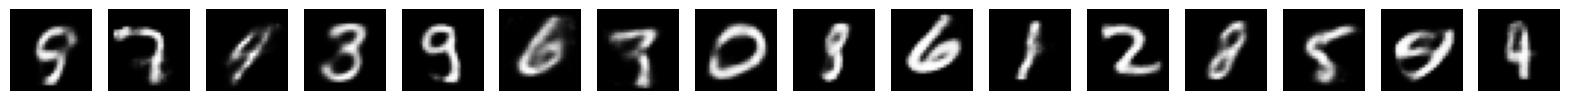

In [59]:
# Sample random latent vectors from a standard normal distribution
n_samples = 16

# Decode the latent vectors to generate images
vae.eval()
with torch.no_grad():
    epsilon = torch.randn(n_samples, latent_dim).to(device)
    generated_images = vae.decode(epsilon).cpu()

# Visualize the generated images
fig, axes = plt.subplots(1, n_samples, figsize=(20, 2))
for i in range(n_samples):
    axes[i].imshow(generated_images[i].view(28, 28), cmap='gray')
    axes[i].axis('off')

plt.show()